<a href="https://colab.research.google.com/github/dylanchapman1/tucsonCrimeDataAnalysis/blob/main/csc380_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Analysis of Crime Patterns in Tucson**

## **Hypotheses**
* **Thefts/Violent Crime vs Area**: Do thefts and violent crimes occur more often in richer or poorer neighborhoods?
* **Crime Rate vs DateTime**: What is the most dangerous time to be in Tucson, and where?

---

## **Data Sources**
The data used for this analysis is sourced from the following links:

* [Tucson Police Reported Crimes](https://gisdata.tucsonaz.gov/datasets/tucson-police-reported-crimes/explore)
* [Tucson Police Arrests](https://drive.google.com/file/d/1xn_37c6IzRy_zXme7iIWtl--YBCEc3w9/view?usp=sharing)
* [Neighborhood Income](https://drive.google.com/file/d/1jbFdicF-6eE0W_GMXujiITnYtOj_AQTB/view?usp=sharing)
* [Geocoded Addresses from Arrests via Census Bureau API](https://geocoding.geo.census.gov/geocoder/)
* [Neighborhood geocoded data from the OpenCage API](https://opencagedata.com/api) (1,000 free requests / day)

---

## **Setup and Libraries**

The following libraries are used to analyze and model the data:
* `pandas` and `numpy`: Data manipulation and analysis.
* `matplotlib` and `seaborn`: Data visualization.
* `statsmodels` and `scikit-learn`: Statistical modeling and machine learning.
* `geopy`: Geocoding for location-based analysis.

The code assumes the datasets have been downloaded and stored in Google Drive for easy access during analysis.


In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# this assumes you have downloaded the training dataset to the My Drive/datasets folder.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Merging and Normalizing Datasets**

To analyze crime patterns, we need to merge and normalize the following datasets:
1. **Reported Crime Dataset**: Contains details about reported crimes in Tucson.
2. **Arrests Dataset**: Provides information about arrests, including the datetime of arrest.

The merged dataset will be normalized to prepare for further analysis.


In [ ]:
# Load the data
reported_crime = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Reported_Crimes.csv",
    parse_dates=["DateOccurred"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

arrests = pd.read_csv(
    "/content/drive/My Drive/datasets/Tucson_Police_Arrests_-_2021_-_Open_Data.csv",
    parse_dates=["date_arr", "datetime_arr"],
    date_parser=lambda x: pd.to_datetime(x, errors='coerce')
)

# Merge Data using their case id
merged_data = pd.merge(arrests,reported_crime, left_on='case_id', right_on='IncidentID', how='inner')

# **Logistic Regression of Time vs High-Crime Probability**

The following code performs a logistic regression analysis to predict the likelihood of high-crime periods based on the hour of the day and the division in Tucson. This approach transforms crime counts into a binary high/low crime indicator, enabling a focus on identifying high-risk times and locations.

---

## **Steps**:

1. **Verify Data**:
   - Inspect the shape and structure of the merged dataset after loading.

2. **Extract Hour**:
   - Extract the hour from the `TimeOccur` field using a custom function.
   - Drop rows with missing hour values for cleaner analysis.

3. **Aggregate Crime Counts**:
   - Group the data by Division and Hour to calculate the crime counts for each combination.
   - Create a binary HighCrime variable based on whether the crime count exceeds the median.

4. **Create Dummy Variables**:
   - Generate dummy variables for `Division` to encode categorical data for regression.

5. **Model Building**:
   - Fit a Logistic Regression model to predict the likelihood of high-crime periods.
   - Evaluate the model's performance with metrics such as accuracy, precision, recall, and F1-score.

6. **Visualization**:
   - Plot hourly probabilities of high-crime periods for each division using line plots.
   - Generate a heatmap to visualize the probability of high-crime periods across divisions and hours.


Shape of crime_counts: (99, 3)
  Division  Hour  CrimeCount
0     East   0.0          71
1     East   1.0          54
2     East   2.0          50
3     East   3.0          53
4     East   4.0          16
Logistic Regression Accuracy: 0.75
Confusion Matrix:
 [[6 4]
 [1 9]]
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.60      0.71        10
           1       0.69      0.90      0.78        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



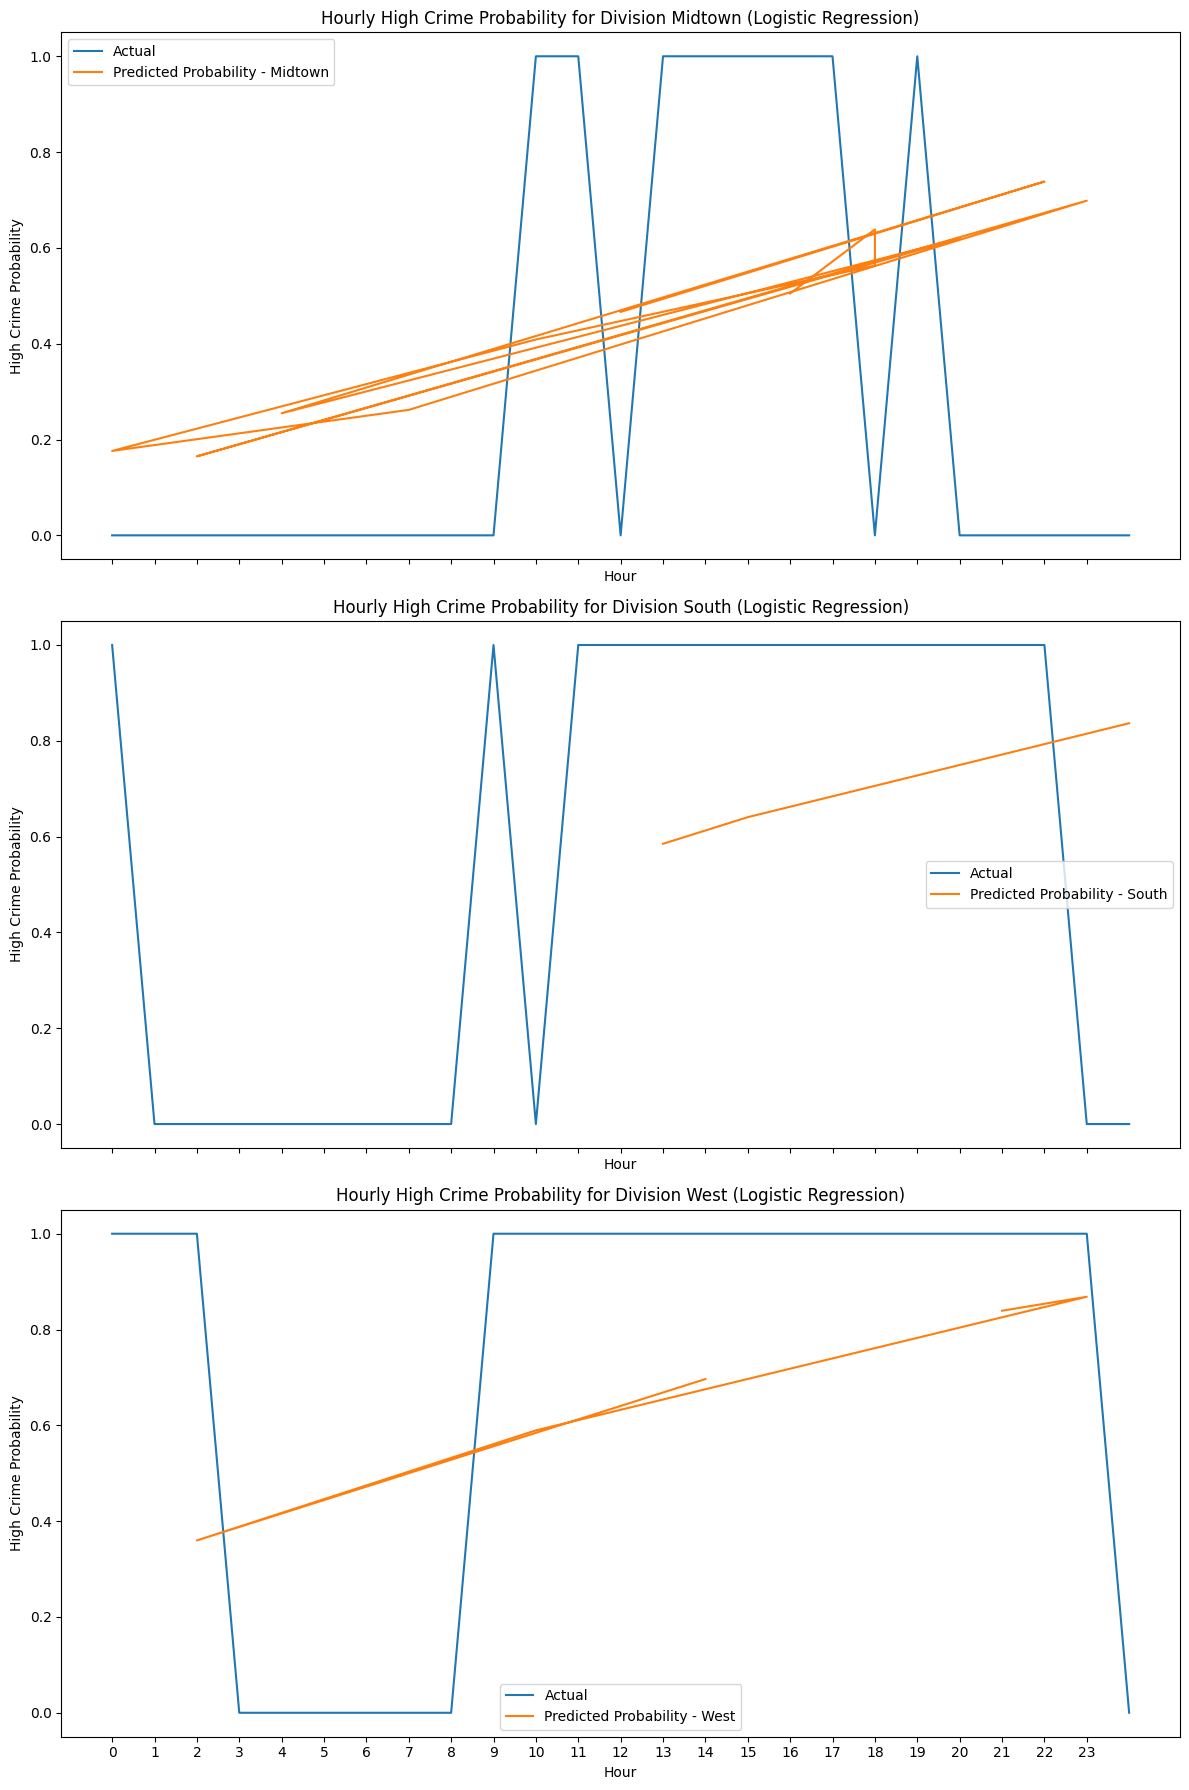

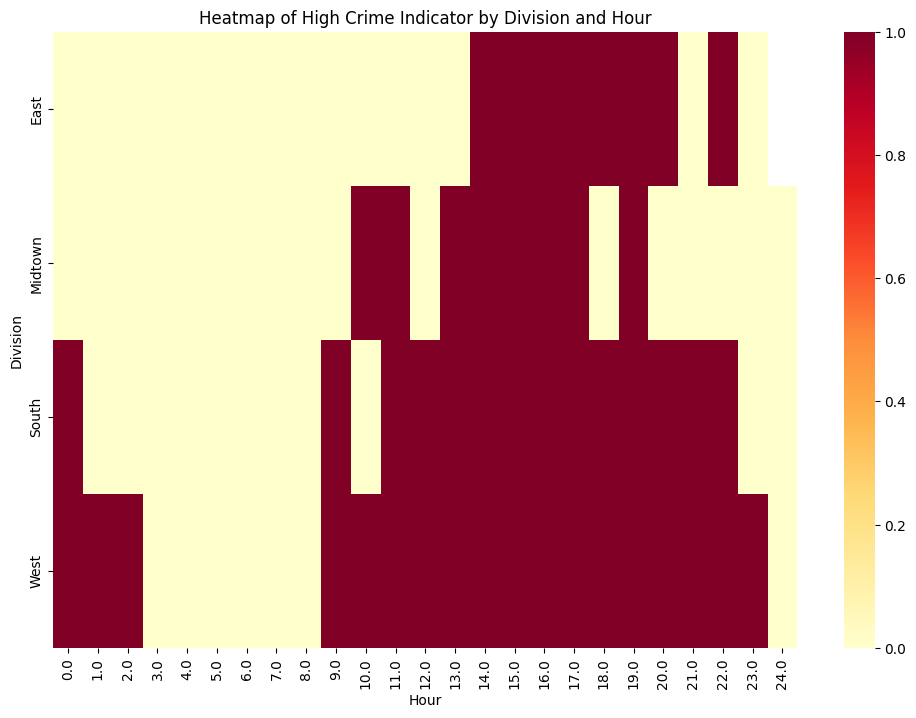

In [ ]:
### Logistic Poisonn Regression ####

def extract_hour(time_str):
    time_str = str(time_str).strip()
    if time_str.isdigit():
        time_str = time_str.zfill(4)
        hour = int(time_str[0:2])
        return hour
    elif time_str == '' or time_str == '0':
        return 0
    else:
        return np.nan

merged_data['Hour'] = merged_data['TimeOccur'].apply(extract_hour)
merged_data.dropna(subset=['Hour'], inplace=True)

# Aggregate Crime Counts by Hour and Division
crime_counts = merged_data.dropna(subset=['Division']).groupby(['Division', 'Hour']).size().reset_index(name='CrimeCount')

print("Shape of crime_counts:", crime_counts.shape)
print(crime_counts.head())

median_crime = crime_counts['CrimeCount'].median()
crime_counts['HighCrime'] = (crime_counts['CrimeCount'] > median_crime).astype(int)

# Create Dummy Variables *before* splitting
division_dummies = pd.get_dummies(crime_counts['Division'], prefix='Division', drop_first=True, dtype=float)
crime_counts = pd.concat([crime_counts, division_dummies], axis=1)

# Model Building
if len(crime_counts) > 1:
    feature_columns = ['Hour'] + list(division_dummies.columns)
    X = crime_counts[feature_columns]
    y = crime_counts['HighCrime']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    logreg_model = LogisticRegression(solver='liblinear', random_state=42)
    logreg_model.fit(X_train, y_train)

    predictions = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

    print(f"Logistic Regression Accuracy: {accuracy}")
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", class_report)

    probabilities = pd.DataFrame(logreg_model.predict_proba(X_test), index=X_test.index)



    # Visualizations (Corrected)
    X_test['Division'] = X_test[[col for col in X_test.columns if 'Division' in col]].idxmax(axis=1).apply(lambda x: x.split('_')[1] if '_' in x else x)
    num_divisions = len(X_test['Division'].unique())
    fig, axes = plt.subplots(nrows=num_divisions, ncols=1, figsize=(12, 6 * num_divisions), sharex=True)



    i = 0


    for division in sorted(X_test['Division'].unique()):
        division_str = str(division)
        division_data = crime_counts[crime_counts['Division'] == division]



        X_test_division = X_test[X_test['Division'] == division]
        division_probabilities = probabilities.loc[X_test_division.index]
        axes[i].plot(division_data['Hour'], division_data['HighCrime'], label="Actual")
        axes[i].plot(X_test_division['Hour'], division_probabilities[1], label=f"Predicted Probability - {division_str}")
        axes[i].set_xlabel("Hour")
        axes[i].set_ylabel("High Crime Probability")
        axes[i].set_title(f"Hourly High Crime Probability for Division {division_str} (Logistic Regression)")
        axes[i].legend()
        axes[i].set_xticks(range(24))

        i += 1


    plt.tight_layout()
    plt.show()



    # Heatmap
    crime_heatmap = crime_counts.pivot_table(index='Division', columns='Hour', values='HighCrime')  # Uses 'HighCrime'
    plt.figure(figsize=(12, 8))
    sns.heatmap(crime_heatmap, cmap="YlOrRd")
    plt.title("Heatmap of High Crime Indicator by Division and Hour")
    plt.show()




else:
    print("Not enough data to build or evaluate model")

# **Ridge Regression Analysis for Hourly Crime Patterns**

This section uses Ridge Regression to model and analyze crime counts by hour for each division in Tucson. Ridge Regression helps prevent overfitting by applying regularization to the regression coefficients.

---

## **Steps**:

1. **Group Data by Division**:
   - Crime data is grouped by `Division` (district) to create individual models for each division.

2. **Train Ridge Regression**:
   - A Ridge Regression model is trained for each division using `Hour` as the predictor and `CrimeCount` as the target.

3. **Store and Visualize Results**:
   - The model, features, target values, and predictions are stored for each division.
   - Scatter plots with regression lines are created to visualize the fit for each division.


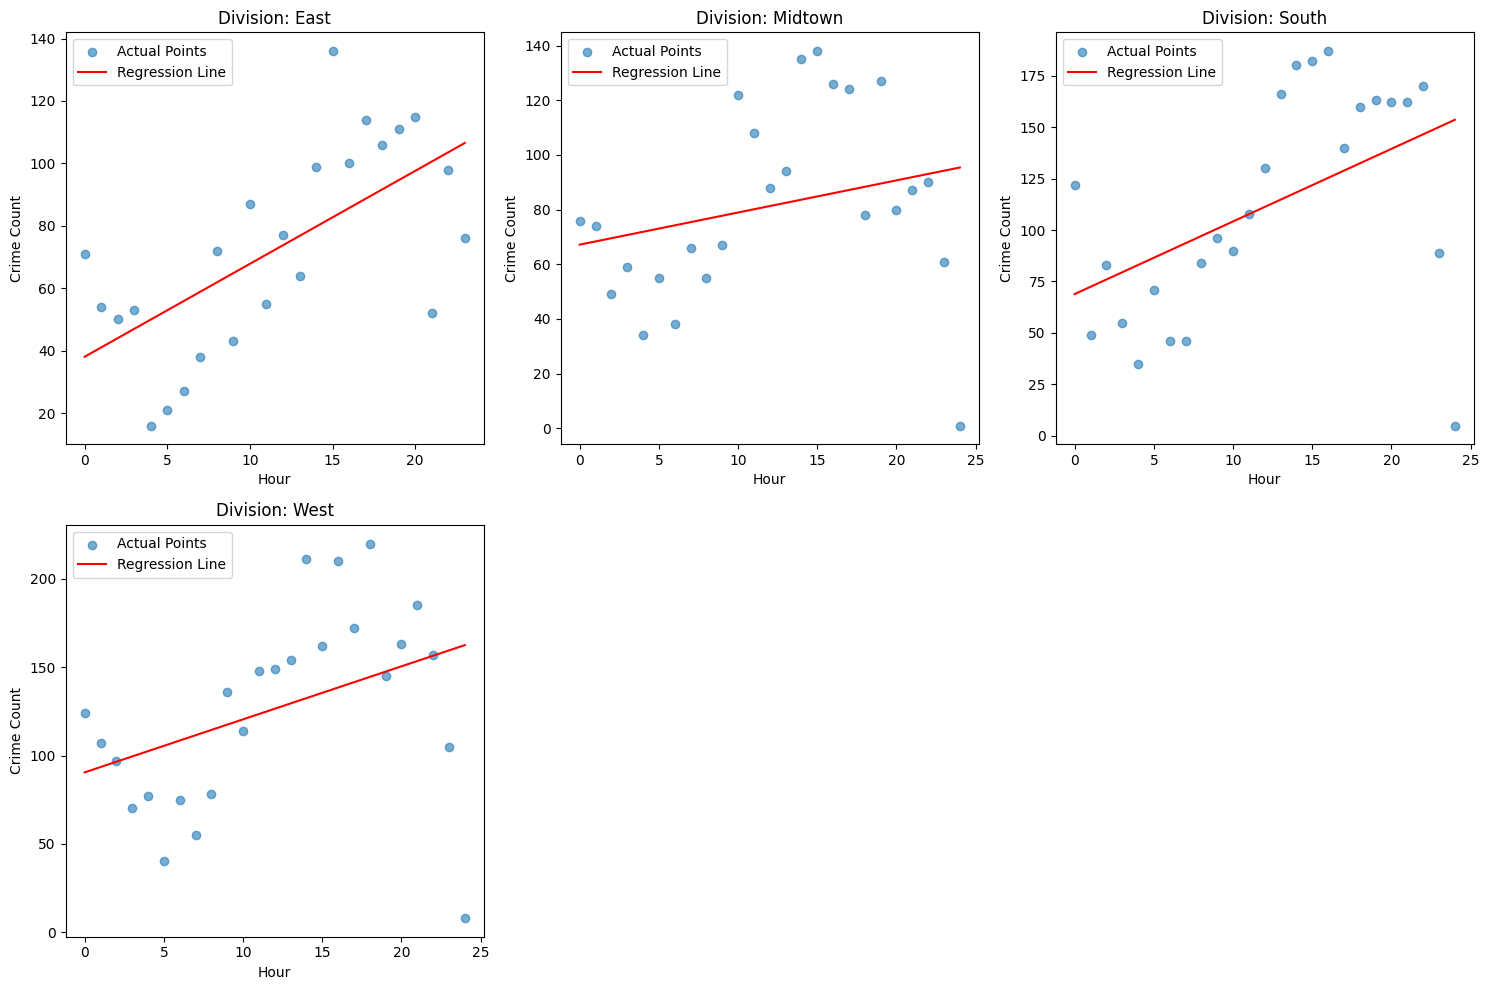

In [ ]:

# Initialize results storage
division_results = {}

# Group by Division (District)
grouped_data = crime_counts.groupby('Division')

# Multi-Ridge Regression for Each District
for division, group in grouped_data:
    if len(group) < 5:  # Skip divisions with too few data points
        continue

    # Features and target
    features = group[['Hour']]
    target = group['CrimeCount']

    # Train Ridge Regression
    ridge_model = Ridge(alpha=1.0, random_state=42)  # Regularization strength
    ridge_model.fit(features, target)

    # Predict
    predictions = ridge_model.predict(features)

    # Store results
    division_results[division] = {
        'Model': ridge_model,
        'Features': features,
        'Target': target,
        'Predictions': predictions
    }

# Plot Regression Line with Actual Points
n_divisions = len(division_results)
n_cols = 3
n_rows = (n_divisions // n_cols) + (1 if n_divisions % n_cols else 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for ax, (division, results) in zip(axes, division_results.items()):
    features = results['Features']
    target = results['Target']
    predictions = results['Predictions']

    # Plot actual points
    ax.scatter(features, target, alpha=0.6, label='Actual Points')

    # Plot regression line
    sorted_indices = np.argsort(features['Hour'])
    ax.plot(
        features.iloc[sorted_indices],
        predictions[sorted_indices],
        color='red',
        label='Regression Line'
    )

    ax.set_title(f'Division: {division}')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Crime Count')
    ax.legend()

# Remove unused axes
for ax in axes[len(division_results):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


# Linear Regression of Wealth Index vs. Crime Count

Linear Regression Analysis of Wealth Index vs. Crime Counts
This section uses Linear Regression to model and analyze crime counts by neighborhood in Tucson. The linear regression uses two main features, wealth_index and population density. Wealth index's importance in this model is important as it is the main independent variable in the study. Population Density is an important factor to consider, as more populous areas will be more prone to crime, simply due to higher traffic. To neutralize the effects of this confounding variable, we normalize the crime counts for population density of the district.

Steps:
- Clean and Merge Data:

  This model requires additional data to be used, so in order to calculate population density, we must first gather population and neighborhood area data points

- Train Linear Regression:

  A Linear Regression model is trained using wealth index normalized for population density as the predictor and crime count as the measured result.

- Store and Visualize Results:

  The model, features, target values, and predictions are stored for further analysis, and scatter plots with regression lines are created to visualize the fit.

Step 1:
Clean and merge data

In [ ]:
# Refresh and load new datasets, merge into master dataframe
neighborhood_size            = pd.read_csv('/content/drive/My Drive/datasets/neighborhood_data.csv')
neighborhood_data_population = pd.read_csv('/content/drive/My Drive/datasets/Neighborhood_Population_Statistics.csv')
geocoded_data                = pd.read_csv('/content/drive/My Drive/datasets/geocoded_tucson_arrests.csv')
neighborhood_data            = pd.read_csv('/content/drive/My Drive/datasets/neighborhood_data_with_coordinates.csv')

# Vectorized Haversine function
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371.0  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Prepare output column for wealth index
geocoded_data['WLTHINDXCY'] = np.nan

# Convert coordinates to NumPy arrays
neighborhood_lats = neighborhood_data['Latitude'].to_numpy()
neighborhood_lons = neighborhood_data['Longitude'].to_numpy()
neighborhood_wlthindxcy = neighborhood_data['WLTHINDXCY'].to_numpy()

# Find the nearest neighborhood for each arrest
for index, row in geocoded_data.iterrows():
    lat1, lon1 = row['Latitude'], row['Longitude']
    distances = haversine_vectorized(lat1, lon1, neighborhood_lats, neighborhood_lons)
    nearest_idx = np.argmin(distances)
    geocoded_data.at[index, 'WLTHINDXCY'] = neighborhood_wlthindxcy[nearest_idx]

# Calculate average WLTHINDXCY and crime count for each unique 'NHA_NAME'
nha_summary = (
    geocoded_data.groupby("NHA_NAME")
        .agg(
        avg_wealth=("WLTHINDXCY", "mean"),
        avg_time=("time_arr", "mean"),
        crime_count=("NHA_NAME", "size")  # Count occurrences as crime count
    ).reset_index()
)

# Rename external dataset columns for merging
neighborhood_size.rename(columns={'NAME': 'NHA_NAME'}, inplace=True)
neighborhood_data_population.rename(columns={'NAME': 'NHA_NAME'}, inplace=True)

# Merge Area and Population data into nha_summary
nha_summary = nha_summary.merge(neighborhood_size[['NHA_NAME', 'area']], on='NHA_NAME', how='left')
nha_summary = nha_summary.merge(neighborhood_data_population[['NHA_NAME', 'TOTPOP_CY']], on='NHA_NAME', how='left')
nha_summary.rename(columns={'area': 'Area', 'TOTPOP_CY': 'Population'}, inplace=True)

# Remove commas and convert 'Area' and 'Population' to numeric
nha_summary['Area'] = nha_summary['Area'].str.replace(',', '', regex=True).astype(float) / (5280 ** 2)

# Calculate population density
nha_summary["Pop Density (persons/mi²)"] = nha_summary["Population"] / nha_summary["Area"]

# Create Crime Count columns (crime count normalized by population density)
nha_summary['Crime Count'] = nha_summary['crime_count'] / nha_summary['Pop Density (persons/mi²)']

# Handle infinite and missing values
nha_summary.replace([np.inf, -np.inf], np.nan, inplace=True)
nha_summary.dropna(subset=['Crime Count'], inplace=True)

# Set thresholds for outliers
crime_outlier_threshold      = nha_summary['crime_count'].quantile(0.95)
population_outlier_threshold = nha_summary['Population'].quantile(0.95)

# Identify outliers for each plot
crime_outliers      = nha_summary[nha_summary['crime_count'] > crime_outlier_threshold]
population_outliers = nha_summary[nha_summary['Population']  > population_outlier_threshold]

Plots

Plot 1: SNS simple regression of Crime vs Population

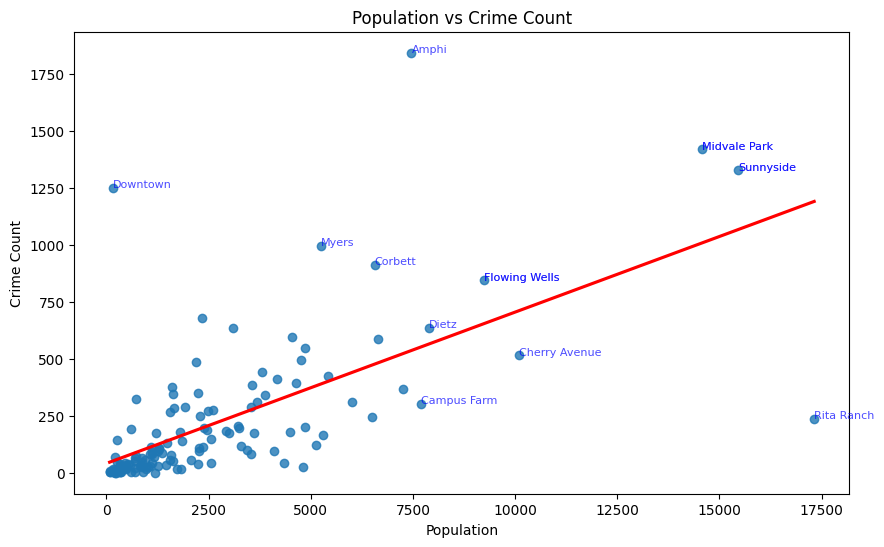

In [ ]:
# Population vs Crime Count with simple SNS regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x=nha_summary['Population'],
    y=nha_summary['crime_count'],
    scatter=True,
    line_kws={"color": "red"},
    ci=None
)

# Annotate outliers with neighborhood names
for i, row in crime_outliers.iterrows():
    plt.text(
        row['Population'],
        row['crime_count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

for i, row in population_outliers.iterrows():
    plt.text(
        row['Population'],
        row['crime_count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

plt.title('Population vs Crime Count')
plt.xlabel('Population')
plt.ylabel('Crime Count')
plt.show()

Plot 2: Regression plot using custom linear regression

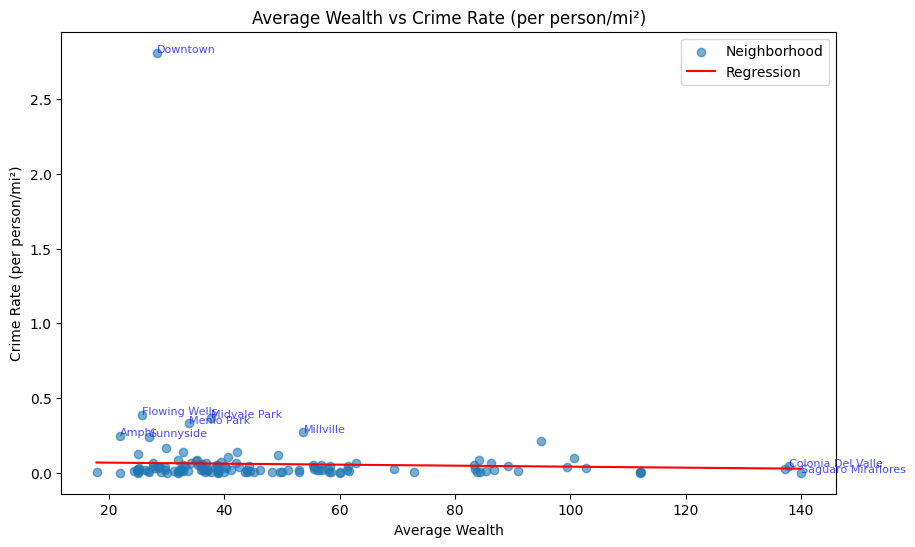

In [ ]:

# Prepare the data
X = nha_summary[['avg_wealth', 'Pop Density (persons/mi²)']]
y = nha_summary['Crime Count']

# Impute missing values manually
X['avg_wealth'].fillna(X['avg_wealth'].median(), inplace=True)
X['Pop Density (persons/mi²)'].fillna(X['Pop Density (persons/mi²)'].median(), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(model, X_scaled, y, cv=5, scoring='r2')

# Get wider range of x-values for 'avg_wealth' based on the dataset
x_values = np.linspace(nha_summary['avg_wealth'].min(), nha_summary['avg_wealth'].max(), 100).reshape(-1, 1)

# Use the mean of 'Pop Density (persons/mi²)' for the trend line
mean_pop_density = nha_summary['Pop Density (persons/mi²)'].mean()
x_combined = np.hstack((x_values, np.full_like(x_values, mean_pop_density)))  # Combine features

# Generate predictions using trained model
y_trend = model.predict(StandardScaler().fit_transform(x_combined))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(nha_summary['avg_wealth'], nha_summary['Crime Count'], alpha=0.6, label='Neighborhood')
plt.plot(x_values, y_trend, color="red", label="Regression")

# Annotate outliers with neighborhood names
crime_norm_outlier_threshold = nha_summary['Crime Count'].quantile(0.95)
wealth_outlier_threshold     = nha_summary['avg_wealth'].quantile(0.99)

crime_norm_outliers = nha_summary[nha_summary['Crime Count'] > crime_norm_outlier_threshold]
wealth_outliers     = nha_summary[nha_summary['avg_wealth']  > wealth_outlier_threshold]

for i, row in crime_norm_outliers.iterrows():
    plt.text(
        row['avg_wealth'],
        row['Crime Count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

for i, row in wealth_outliers.iterrows():
    plt.text(
        row['avg_wealth'],
        row['Crime Count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

plt.title('Average Wealth vs Crime Rate (per person/mi²)')
plt.xlabel('Average Wealth')
plt.ylabel('Crime Rate (per person/mi²)')
plt.legend()
plt.show()


# This commented out code is an SNS plot plotting the exact same regression that
# is currently plotted by the custom model

# Plot avg_wealth vs normalized crime count with regression line
# plt.figure(figsize=(10, 6))
# sns.regplot(
#     x=nha_summary['avg_wealth'],
#     y=nha_summary['Crime Count'],
#     scatter=True,
#     line_kws={"color": "red"},  # Regression line color
#     ci=None  # No confidence interval
# )

# # Annotate outliers with neighborhood names
# for i, row in crime_norm_outliers.iterrows():
#     plt.text(
#         row['avg_wealth'],
#         row['Crime Count'],
#         row['NHA_NAME'],
#         fontsize=8,
#         color='blue',
#         alpha=0.7
#     )

# for i, row in wealth_outliers.iterrows():
#     plt.text(
#         row['avg_wealth'],
#         row['Crime Count'],
#         row['NHA_NAME'],
#         fontsize=8,
#         color='blue',
#         alpha=0.7
#     )

# plt.title('Average Wealth vs Crime Count')
# plt.xlabel('Average Wealth')
# plt.ylabel('Crime Count (per person/mi²)')
# plt.show()

Analysis of Regression results

In [ ]:
print("Linear Regression Model Summary:")
print("Model Coefficients:")
print(f"Intercept: {model.intercept_}")
print(f"Coefficient for Average Wealth: {model.coef_[0]}")
print(f"Coefficient for Population Density: {model.coef_[1]}")

print("")

print("Model Evaluation Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared on test set: {r2}")
print(f"Cross-validated R-squared: {np.mean(cv_scores)} +/- {np.std(cv_scores)}")

Linear Regression Model Summary:
Model Coefficients:
Intercept: 0.04775563317289082
Coefficient for Average Wealth: -0.012001475066905732
Coefficient for Population Density: -0.011706051818236122

Model Evaluation Metrics:
Mean Squared Error: 0.28978987087911
Root Mean Squared Error: 36.49264740022716
Mean Absolute Error: 28.27970631603459
R-squared on test set: -0.009187623697024971
Cross-validated R-squared: -1.8412500994405385 +/- 1.7946663123548765


Another Model, ignoring the most glaring outlier (Downtown)


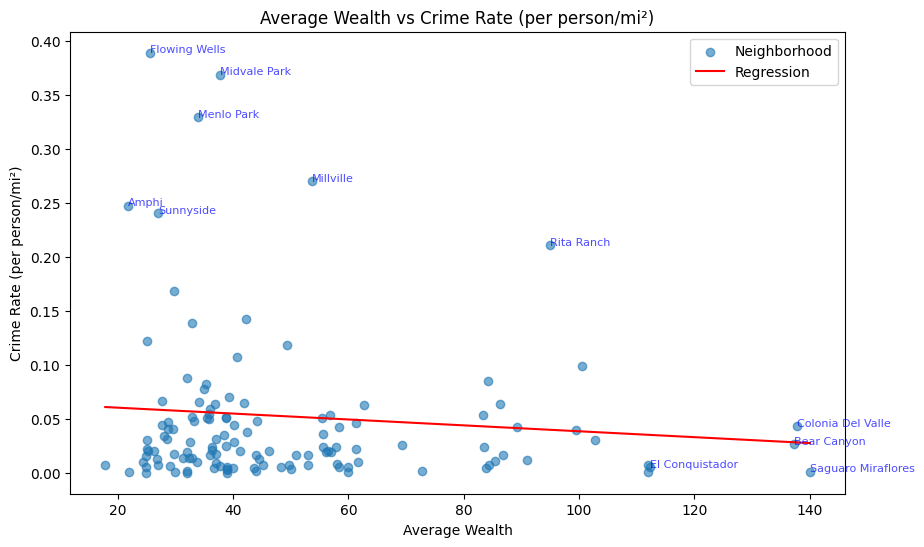

In [ ]:
nha_summary.drop(nha_summary[nha_summary['NHA_NAME'] == 'Downtown'].index, inplace=True)
# Prepare the data
X = nha_summary[['avg_wealth', 'Pop Density (persons/mi²)']]
y = nha_summary['Crime Count']

# Impute missing values manually
X['avg_wealth'].fillna(X['avg_wealth'].median(), inplace=True)
X['Pop Density (persons/mi²)'].fillna(X['Pop Density (persons/mi²)'].median(), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model_adjusted = LinearRegression()
model_adjusted.fit(X_train, y_train)

# Predictions on the test set
y_pred = model_adjusted.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Cross-validation
cv_scores = cross_val_score(model_adjusted, X_scaled, y, cv=5, scoring='r2')

# Get wider range of x-values for 'avg_wealth' based on the dataset
x_values = np.linspace(nha_summary['avg_wealth'].min(), nha_summary['avg_wealth'].max(), 100).reshape(-1, 1)

# Use the mean of 'Pop Density (persons/mi²)' for the trend line
mean_pop_density = nha_summary['Pop Density (persons/mi²)'].mean()
x_combined = np.hstack((x_values, np.full_like(x_values, mean_pop_density)))  # Combine features

# Generate predictions using trained model
y_trend = model_adjusted.predict(StandardScaler().fit_transform(x_combined))

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(nha_summary['avg_wealth'], nha_summary['Crime Count'], alpha=0.6, label='Neighborhood')
plt.plot(x_values, y_trend, color="red", label="Regression")

# Annotate outliers with neighborhood names
crime_norm_outlier_threshold = nha_summary['Crime Count'].quantile(0.95)
wealth_outlier_threshold     = nha_summary['avg_wealth'].quantile(0.97)

crime_norm_outliers = nha_summary[nha_summary['Crime Count'] > crime_norm_outlier_threshold]
wealth_outliers     = nha_summary[nha_summary['avg_wealth']  > wealth_outlier_threshold]

for i, row in crime_norm_outliers.iterrows():
    plt.text(
        row['avg_wealth'],
        row['Crime Count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

for i, row in wealth_outliers.iterrows():
    plt.text(
        row['avg_wealth'],
        row['Crime Count'],
        row['NHA_NAME'],
        fontsize=8,
        color='blue',
        alpha=0.7
    )

plt.title('Average Wealth vs Crime Rate (per person/mi²)')
plt.xlabel('Average Wealth')
plt.ylabel('Crime Rate (per person/mi²)')
plt.legend()
plt.show()

In [ ]:

print("Linear Regression Model Summary:")
print("Model Coefficients:")
print(f"Intercept: {model_adjusted.intercept_}")
print(f"Coefficient for Average Wealth: {model_adjusted.coef_[0]}")
print(f"Coefficient for Population Density: {model_adjusted.coef_[1]}")
print("")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared on test set: {r2}")
print(f"Cross-validated R-squared: {np.mean(cv_scores)} +/- {np.std(cv_scores)}")

Linear Regression Model Summary:
Model Coefficients:
Intercept: 0.04425273013774635
Coefficient for Average Wealth: -0.009725322957196563
Coefficient for Population Density: -0.009419121512289862

Mean Squared Error: 0.005816706499206416
Root Mean Squared Error: 36.49264740022716
Mean Absolute Error: 28.27970631603459
R-squared on test set: 0.033987913701481354
Cross-validated R-squared: -0.1275881197510023 +/- 0.1427634359242814


# **5-Fold Cross-Validation for Poisson Regression**

This section applies Poisson regression with 5-fold cross-validation to model hourly crime counts, incorporating division-level dummy variables for a more granular analysis. The model evaluates its predictive performance across multiple metrics.

---

## **Steps**:
1. **Prepare Features and Target**:
   - Include `Hour` and division dummy variables as predictors.
   - Add a constant term for the Poisson regression model.

2. **5-Fold Cross-Validation**:
   - Split the data into 5 folds for training and testing.
   - Train the Poisson regression model on each fold and make predictions on the test set.

3. **Evaluate Performance**:
   - Metrics include:
     - R² (approximated for Poisson regression)
     - RMSE (Root Mean Squared Error)
     - MAE (Mean Absolute Error)

4. **Summarize Results**:
   - Store metrics for each fold.
   - Compute overall mean and standard deviation for each metric.


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Prepare Features and Target
feature_columns = ['Hour'] + list(division_dummies.columns)
X = crime_counts[feature_columns]
y = crime_counts['CrimeCount']

# Add a constant for statsmodels Poisson regression
X = sm.add_constant(X)

# Initialize 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = []

for train_index, test_index in kf.split(X):
    # Split data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    try:
        # Train Poisson Regression Model
        poisson_model = sm.Poisson(y_train, X_train).fit(disp=False)

        # Predict
        predictions = poisson_model.predict(X_test)

        # Evaluate
        mse = mean_squared_error(y_test, predictions)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, predictions)
        r2 = 1 - (mse / np.var(y_test))  # R² approximation for Poisson regression

        # Store results
        cv_results.append({
            'Fold': len(cv_results) + 1,
            'R²': r2,
            'RMSE': rmse,
            'MAE': mae
        })
    except Exception as e:
        print(f"Error in fold {len(cv_results) + 1}: {e}")

# Summarize Results
cv_results_df = pd.DataFrame(cv_results)

print("5-Fold Cross-Validation Results for Poisson Regression:")
print(cv_results_df)

# Overall Metrics
mean_r2 = cv_results_df['R²'].mean()
std_r2 = cv_results_df['R²'].std()
mean_rmse = cv_results_df['RMSE'].mean()
std_rmse = cv_results_df['RMSE'].std()
mean_mae = cv_results_df['MAE'].mean()
std_mae = cv_results_df['MAE'].std()

print(f"Overall Mean R-squared: {mean_r2:.3f} +/- {std_r2:.3f}")
print(f"Overall Mean RMSE: {mean_rmse:.3f} +/- {std_rmse:.3f}")
print(f"Overall Mean MAE: {mean_mae:.3f} +/- {std_mae:.3f}")


5-Fold Cross-Validation Results for Poisson Regression:
   Fold        R²       RMSE        MAE
0     1  0.061989  50.943067  35.893016
1     2  0.431308  38.828870  34.911674
2     3 -0.116605  39.016645  33.045600
3     4 -0.356300  55.906370  35.280211
4     5  0.465951  37.297100  28.725999
Overall Mean R-squared: 0.097 +/- 0.354
Overall Mean RMSE: 44.398 +/- 8.451
Overall Mean MAE: 33.571 +/- 2.909


# **5-Fold Cross-Validation for Ridge Regression**

This section applies Ridge Regression with 5-fold cross-validation to model hourly crime counts for each division. Cross-validation ensures robust evaluation by splitting the data into multiple training and testing sets.

---

## **Steps**:
1. **Group Data by Division**:
   - Crime data is grouped by `Division` (district) for individual analysis.

2. **5-Fold Cross-Validation**:
   - Perform 5 splits of the data for training and testing.
   - For each split, train the Ridge Regression model and evaluate performance using:
     - R² (Coefficient of Determination)
     - RMSE (Root Mean Squared Error)

3. **Aggregate Results**:
   - Calculate the mean and standard deviation of R² and RMSE for each division.
   - Summarize results in a DataFrame for comparison.

4. **Overall Metrics**:
   - Compute overall mean and standard deviation of R² and RMSE across all divisions.

---

In [ ]:
# Initialize results storage
cv_results = []

# Apply 5-Fold Cross-Validation for Each District
for division, group in grouped_data:
    if len(group) < 5:  # Skip divisions with too few data points
        continue

    # Features and target
    features = group[['Hour']]
    target = group['CrimeCount']

    # Initialize 5-Fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    division_r2 = []
    division_rmse = []

    for train_index, test_index in kf.split(features):
        # Split data
        X_train, X_test = features.iloc[train_index], features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]

        # Train Ridge Regression
        ridge_model = Ridge(alpha=1.0)
        ridge_model.fit(X_train, y_train)

        # Predict
        predictions = ridge_model.predict(X_test)

        # Evaluate
        r2 = r2_score(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        division_r2.append(r2)
        division_rmse.append(rmse)

    # Store results for this division
    cv_results.append({
        'Division': division,
        'Mean_R²': np.mean(division_r2),
        'Std_R²': np.std(division_r2),
        'Mean_RMSE': np.mean(division_rmse),
        'Std_RMSE': np.std(division_rmse)
    })

# Summarize Results
cv_results_df = pd.DataFrame(cv_results).sort_values(by='Mean_R²', ascending=False)

print("5-Fold Cross-Validation Results of Ridge Regression:")
print(cv_results_df[['Division', 'Mean_R²', 'Std_R²', 'Mean_RMSE', 'Std_RMSE']])

# Overall Metrics
overall_mean_r2 = cv_results_df['Mean_R²'].mean()
overall_std_r2 = cv_results_df['Mean_R²'].std()
overall_mean_rmse = cv_results_df['Mean_RMSE'].mean()
overall_std_rmse = cv_results_df['Mean_RMSE'].std()

print(f"Overall Mean R²: {overall_mean_r2:.3f} ± {overall_std_r2:.3f}")
print(f"Overall Mean RMSE: {overall_mean_rmse:.3f} ± {overall_std_rmse:.3f}")


5-Fold Cross-Validation Results of Ridge Regression:
  Division   Mean_R²    Std_R²  Mean_RMSE   Std_RMSE
3     West  0.140556  0.317443  47.779504  19.352959
2    South -0.029882  0.612045  49.216521  15.689774
1  Midtown -0.193024  0.498574  35.185722  15.343048
0     East -0.655092  1.867346  25.982851   4.792659
Overall Mean R²: -0.184 ± 0.342
Overall Mean RMSE: 39.541 ± 11.019


# 5-Fold Cross-Validation for Linear Regression

In [ ]:
# Prepare the data
X = nha_summary[['avg_wealth', 'Pop Density (persons/mi²)']]
y = nha_summary['Crime Count']
X['avg_wealth'].fillna(X['avg_wealth'].median(), inplace=True)
X['Pop Density (persons/mi²)'].fillna(X['Pop Density (persons/mi²)'].median(), inplace=True)

# setup
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# 5-Fold Cross-Validation
for fold_number, (train_index, test_index) in enumerate(kf.split(X_scaled), start=1):
    # data for this fold
    X_train, X_test = X_scaled[train_index], X_scaled[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # calculate metrics
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r_squared = model.score(X_test, y_test)

    # store results for this fold
    fold_results.append({
        'Fold': fold_number,
        'R-squared': r_squared,
        'RMSE': rmse,
        'MAE': mae
    })

# convert fold results to a DataFrame
results_df = pd.DataFrame(fold_results)

# print results
print("")
print("5-Fold Cross-Validation Results for Linear Regression:")
print(results_df)

# calculate overall metrics
overall_r_squared_mean = results_df['R-squared'].mean()
overall_r_squared_std = results_df['R-squared'].std()
overall_rmse_mean = results_df['RMSE'].mean()
overall_rmse_std = results_df['RMSE'].std()
overall_mae_mean = results_df['MAE'].mean()
overall_mae_std = results_df['MAE'].std()
print("")

# overall metrics
print("Overall Cross-Validation Metrics:")
print(f"Mean R-squared: {overall_r_squared_mean}  +/- {overall_r_squared_std}")
print(f"Mean RMSE:       {overall_rmse_mean} +/- {overall_rmse_std}")
print(f"Mean MAE:        {overall_mae_mean}  +/- {overall_mae_std}")


5-Fold Cross-Validation Results for Linear Regression:
   Fold  R-squared      RMSE       MAE
0     1   0.033988  0.076267  0.049767
1     2  -0.217447  0.041559  0.036172
2     3  -0.010044  0.073939  0.047142
3     4  -1.133583  0.034004  0.028204
4     5   0.015626  0.098381  0.054205

Overall Cross-Validation Metrics:
Mean R-squared: -0.2622920311649854  +/- 0.4974457502641453
Mean RMSE:       0.06482988916430661 +/- 0.026604608199587598
Mean MAE:        0.0430980182907449  +/- 0.010653784859502998
